#**Aivle 스쿨 지원 질문, 답변 챗봇 만들기**
# 단계2 : 모델링

## 0.미션

* 다음 세가지 챗봇을 만들고 비교해 봅시다.
* 챗봇1. Word2Vec 임베딩 벡터 기반 머신러닝 분류 모델링
    * Word2Vec 모델을 만들고 임베딩 벡터를 생성합니다.
    * 임베딩 벡터를 이용하여 intent를 분류하는 모델링을 수행합니다.
        * 이때, LightGBM을 추천하지만, 다른 알고리즘을 이용할수 있습니다.
    * 예측된 intent의 답변 중 임의의 하나를 선정하여 출력합니다.
* 챗봇2. 단계별 모델링1
    * 1단계 : type(일상대화 0, 에이블스쿨Q&A 1) 분류 모델 만들기
        * Embedding + LSTM 모델링
    * 2단계 : 사전학습된 Word2Vec 모델을 로딩하여 train의 임베딩벡터 저장
    * 코사인 유사도로 intent 찾아 답변 출력
        * 새로운 문장의 임베딩벡터와 train의 임베딩 벡터간의 코사인 유사도 계산
        * 가장 유사도가 높은 질문의 intent를 찾아 답변 출력하기
* 챗봇3. 단계별 모델링2
    * 1단계 : 챗봇2의 1단계 모델을 그대로 활용
    * 2단계 : FastText 모델 생성하여 train의 임베딩벡터 저장
    * 코사인 유사도로 intent 찾아 답변 출력
        * 새로운 문장의 임베딩벡터와 train의 임베딩 벡터간의 코사인 유사도 계산
        * 가장 유사도가 높은 질문의 intent를 찾아 답변 출력하기

* 챗봇3개에 대해서 몇가지 질문을 입력하고 각각의 답변을 비교해 봅시다.


## 1.환경준비

### (1)라이브러리 설치

#### 1) gensim 3.8.3 설치

In [ ]:
#gensim은 자연어 처리를 위한 오픈소스 라이브러리입니다. 토픽 모델링, 워드 임베딩 등 다양한 자연어 처리 기능을 제공
# 현재 4.x 버전이 최신이지만, 3.8.3 버전으로 진행
!pip install gensim==3.8.3

* [코랩] 위 라이브러리 설치후 런타임 재시작 필요!

#### 2) 형태소 분석을 위한 라이브러리

In [ ]:
# mecab 설치를 위한 관련 패키지 설치
!apt-get install curl git
!apt-get install build-essential
!apt-get install cmake
!apt-get install g++
!apt-get install flex
!apt-get install bison
!apt-get install python-dev
!pip install cython
!pip install mecab-python

In [3]:
# 형태소 기반 토크나이징 (Konlpy)
!python3 -m pip install konlpy
# mecab (ubuntu: linux, mac os 기준)
# 다른 os 설치 방법 및 자세한 내용은 다음 참고: https://konlpy.org/ko/latest/install/#id1
!bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

/bin/bash ../libtool --tag=CXX   --mode=compile g++ -DHAVE_CONFIG_H -I. -I.. -DDIC_VERSION=102   -DMECAB_DEFAULT_RC="\"/usr/local/etc/mecabrc\""    -O3 -Wall  -c -o learner.lo learner.cpp
libtool: compile:  g++ -DHAVE_CONFIG_H -I. -I.. -DDIC_VERSION=102 -DMECAB_DEFAULT_RC=\"/usr/local/etc/mecabrc\" -O3 -Wall -c learner.cpp  -fPIC -DPIC -o .libs/learner.o
libtool: compile:  g++ -DHAVE_CONFIG_H -I. -I.. -DDIC_VERSION=102 -DMECAB_DEFAULT_RC=\"/usr/local/etc/mecabrc\" -O3 -Wall -c learner.cpp -o learner.o >/dev/null 2>&1
/bin/bash ../libtool --tag=CXX   --mode=compile g++ -DHAVE_CONFIG_H -I. -I.. -DDIC_VERSION=102   -DMECAB_DEFAULT_RC="\"/usr/local/etc/mecabrc\""    -O3 -Wall  -c -o libmecab.lo libmecab.cpp
libtool: compile:  g++ -DHAVE_CONFIG_H -I. -I.. -DDIC_VERSION=102 -DMECAB_DEFAULT_RC=\"/usr/local/etc/mecabrc\" -O3 -Wall -c libmecab.cpp  -fPIC -DPIC -o .libs/libmecab.o
libtool: compile:  g++ -DHAVE_CONFIG_H -I. -I.. -DDIC_VERSION=102 -DMECAB_DEFAULT_RC=\"/usr/local/etc/mecabrc\" -O3 

### (2) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

# 필요하다고 판단되는 라이브러리를 추가하세요.
import os

from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import * 

import tensorflow as tf
from keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from keras import Input, Model
from keras import optimizers
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.backend import clear_session

from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.metrics.pairwise import cosine_similarity



* 형태소 분석을 위한 함수를 제공합니다.

In [5]:
from konlpy.tag import Okt, Komoran, Mecab, Hannanum, Kkma

# 다양한 토크나이저를 사용할 수 있는 함수
def get_tokenizer(tokenizer_name):
    if tokenizer_name == "komoran":
        tokenizer = Komoran()
    elif tokenizer_name == "okt":
        tokenizer = Okt()
    elif tokenizer_name == "mecab":
        tokenizer = Mecab()
    elif tokenizer_name == "hannanum":
        tokenizer = Hannanum()
    else:
        # "kkma":
        tokenizer = Kkma()
        
    return tokenizer

In [6]:
# 형태소 분석을 수행하는 함수

def tokenize(tokenizer_name, original_sent, nouns=False):
    # 미리 정의된 몇 가지 tokenizer 중 하나를 선택
    tokenizer = get_tokenizer(tokenizer_name)

    # tokenizer를 이용하여 original_sent를 토큰화하여 tokenized_sent에 저장하고, 이를 반환합니다.
    sentence = original_sent.replace('\n', '').strip()
    if nouns:       
        # tokenizer.nouns(sentence) -> 명사만 추출
        tokens = tokenizer.nouns(sentence)
    else:
        tokens = tokenizer.morphs(sentence)
    tokenized_sent = ' '.join(tokens)
    
    return tokenized_sent

### (3) 데이터 로딩
* 전처리 단계에서 생성한 데이터들을 로딩합니다.
    * train, test
    * 형태소분석 결과 데이터 : clean_train_questions, clean_test_questions

* 구글 드라이브 연결

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
path = '/content/drive/MyDrive/aivle/6차 미니프로젝트/'

* 저장된 .pkl 파일들을 불러옵니다.
* 불러 온 후에는 shape를 확인해 봅시다.

In [9]:
train = joblib.load(os.path.join(path, 'train_data.csv'))
test = joblib.load(os.path.join(path, 'test_data.csv'))

In [10]:
clean_train_questions = joblib.load(os.path.join(path, 'clean_train_question.csv'))
clean_test_questions = joblib.load(os.path.join(path, 'clean_test_question.csv'))

In [11]:
train.shape, test.shape, clean_train_questions.shape, clean_test_questions.shape

((1192, 4), (106, 4), (1192,), (106,))

## 2.챗봇1

* **상세요구사항**
    * Word2Vec을 활용한 LightGBM 모델링(intent 분류)
        * Word2Vec을 이용하여 임베딩벡터 생성하기
            * Word Embedding으로 문장벡터 구하기
        * 임베딩 벡터를 이용하여 ML기반 모델링 수행하기
            * LightGBM 권장(다른 알고리즘을 이용할수 있습니다.)
    * 챗봇 : 모델의 예측결과(intent)에 따라 답변하는 챗봇 만들기
        * 질문을 입력받아, 답변하는 함수 생성

### (1) Word2Vec을 이용하여 임베딩벡터 생성하기
* 'mecab' 형태소 분석기를 이용하여 문장을 tokenize
    * Word2Vec 모델을 만들기 위해서 입력 데이터는 리스트 형태여야 합니다.
    * 그래서 다시 리스트로 저장되도록 토크나이즈 해 봅시다.
* Word Embedding으로 문장벡터를 생성합니다.
    * 먼저 Word2Vec 모델을 만들고, train의 질문들을 문장벡터로 만듭시다.


#### 1) 'mecab' 형태소 분석기를 이용하여 문장을 tokenize

In [12]:
# train 질문들을 리스트로 뽑고
raw_sentences = list(train['Q'])

# train_sentences 리스트 초기화
train_sentences = []

# raw_sentences에서 하나씩 가져와서 토큰화하여 train_sentences에 추가한다
for sent in raw_sentences:
    train_sentences.append(tokenize('mekab', sent).split(' '))

# train_sentences에서 처음 다섯개의 리스트를 출력한다.
print(train_sentences[:5])

[['떨어뜨리', '어서', '핸드폰', '액정', '나가', '었', '어'], ['액정', '나가', '었', '어'], ['노트북', '이', '작동', '이', '안되', '네'], ['노트북', '키보드', '가', '안', '먹히', '네'], ['노트북', '전원', '이', '안', '들어오', '아', '.']]


#### 2) Word Embedding으로 문장벡터 구하기
* Word2Vec
    * 위에서 저장한 입력 데이터를 사용하여 Word2Vec 모델이 생성
    * 모델은 size(단어 벡터의 차원), 
    * window(컨텍스트 창의 크기), 
    * max_vocab_size(고려할 최대 어휘 크기), 
    * min_count(포함할 단어의 최소 빈도)와 같은 특정 하이퍼파라미터로 훈련됩니다.
    * sg : 사용할 훈련 알고리즘 - 1은 skip-gram, 0은 CBOW )

In [13]:
# Word2Vec으로 임베딩할 때, 워드 벡터의 차원 수를 지정하는 변수로 100으로 지정되어 있음.
SIZE = 100
# Word2Vec 모델에서 한 단어의 좌우에 있는 최대 단어의 개수를 지정하는 변수로 3으로 지정되어 있음.
WINDOW = 3
# Word2Vec 모델에 의해 무시될 최소 단어 빈도 수를 지정하는 변수로, 해당 값보다 적게 나타나는 단어
MIN_COUNT = 5

In [14]:
from gensim.models import Word2Vec

# Word2Vec 모델 생성
wv_model = Word2Vec(sentences = train_sentences,  # 학습할 문장
                    size = SIZE,  # 워드 임베딩 벡터의 크기
                    window = WINDOW,  # 문맥 윈도우 크기
                    max_vocab_size = 500,  # 학습에 사용할 최대 단어 수
                    min_count = MIN_COUNT,  # 학습에 사용할 최소 단어 빈도 수
                    workers = 4,  # 학습을 위한 프로세스 수
                    iter = 10,  # 학습 횟수
                    sg = 1)  # skip-gram 방식 사용

* Word2Vec 모델로부터 데이터를 벡터화하기 위한 함수 생성

In [15]:
# Word2Vec 모델로부터 하나의 문장을 벡터화 시키는 함수
def get_sent_embedding(model, embedding_size, tokenized_words):
    # 임베딩 벡터를 0으로 초기화
    feature_vec = np.zeros((embedding_size,), dtype='float32')
    # 단어 개수 초기화
    n_words = 0
    # 모델 단어 집합 생성
    index2word_set = set(model.wv.index2word)
    # 문장의 단어들을 하나씩 반복
    for word in tokenized_words:
        # 모델 단어 집합에 해당하는 단어일 경우에만
        if word in index2word_set:
            # 단어 개수 1 증가
            n_words += 1
            # 임베딩 벡터에 해당 단어의 벡터를 더함
            feature_vec = np.add(feature_vec, model[word])
    # 단어 개수가 0보다 큰 경우 벡터를 단어 개수로 나눠줌 (평균 임베딩 벡터 계산)
    if (n_words > 0):
        feature_vec = np.divide(feature_vec, n_words)
    return feature_vec

In [16]:
# 문장벡터 데이터 셋 만들기
def get_dataset(sentences, model, num_features):
    dataset = list()

    # 각 문장을 벡터화해서 리스트에 저장
    for sent in sentences:
        dataset.append(get_sent_embedding(model, num_features, sent))

    # 리스트를 numpy 배열로 변환하여 반환
    sent_embedding_vectors = np.stack(dataset)
    
    return sent_embedding_vectors

* 이제 학습데이터의 Q를 Word2Vec 모델을 사용하여 벡터화 합니다.

In [17]:
pre_trained = Word2Vec.load('/content/drive/MyDrive/aivle/6차 미니프로젝트/ko.bin')

In [18]:
# 학습 데이터의 문장들을 Word2Vec 모델을 사용하여 벡터화
train_data_vecs = get_dataset(train_sentences, wv_model, SIZE)
# test_data_vecs = get_dataset(clean_test_questions, pre_trained, 200)

In [19]:
train_data_vecs.shape

(1192, 100)

* 훈련된 Word2Vec 모델을 사용하여 문장 목록에 대한 문장 임베딩을 생성하고 이를 2차원 numpy 배열에 저장합니다. 
* 그런 다음 이러한 임베딩을 다양한 기계 학습 모델의 입력 기능으로 사용할 수 있습니다

### (2) 분류 모델링
* 데이터 분할
    * x, y
        * x : 이전 단계에서 저장된 임베딩벡터(train_data_vecs)
        * y : intent 값들
    * train, val
        * train_test_split 활용
* 머신러닝 모델링
    * lightGBM, RandomForest 등을 활용하여 학습
    * 필요하다면 hyper parameter 튜닝을 시도해도 좋습니다.
* validation set으로 검증해 봅시다.

In [20]:
# X와 y 데이터 분리
x = train_data_vecs
y = np.array(list(train['intent']))

# Train-Test split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, random_state = 42)
display(np.unique(y_val, return_counts = True))
display(np.unique(y_val, return_counts = True)[1].shape)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2, stratify = y, random_state = 42)
display(np.unique(y_val, return_counts = True))
display(np.unique(y_val, return_counts = True)[1].shape)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 12, 13, 14, 15, 16, 17, 19,
        20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]),
 array([ 1,  1,  9,  1,  1,  4,  1, 13,  3,  1,  1,  5,  2,  1,  2,  3,  1,
         9,  4,  2,  3,  1,  1,  4,  3,  5,  2,  8,  4, 29,  4,  2,  3,  3,
         1,  4, 13,  7, 10,  1,  8,  6, 10, 16,  2,  5,  1,  7,  4,  3,  4]))

(51,)

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53]),
 array([ 3,  3,  7,  1,  1,  1,  1, 13,  2,  1,  2,  2,  4,  1,  2,  2,  1,
         2,  1,  6,  4,  1,  2,  1,  1,  2,  3,  5,  3,  6,  7, 27,  4,  4,
         4,  3,  3,  4, 12,  8,  8,  3,  8,  4,  8, 12,  4,  4,  4, 12,  4,
         4,  4]))

(53,)

* 모델1

In [21]:
model1 = LGBMClassifier(n_estimators=200, objective = 'muticlass')
model1.fit(x_train, y_train)

LGBMClassifier(n_estimators=200, objective='muticlass')

In [22]:
y_pred = model1.predict(x_val)
print(accuracy_score(y_val, y_pred))
# print(confusion_matrix(y_val, y_pred))
# print(classification_report(y_val, y_pred))

0.5313807531380753


In [23]:
import joblib

joblib.dump(model1, path + 'lgbm_classifier.pkl')

['/content/drive/MyDrive/aivle/6차 미니프로젝트/lgbm_classifier.pkl']

* 모델2

In [24]:
from sklearn.ensemble import RandomForestClassifier
model2 = RandomForestClassifier(n_estimators=200)
model2.fit(x_train, y_train)

RandomForestClassifier(n_estimators=200)

In [25]:
# y_pred = model.predict(x_val)
# print(confusion_matrix(y_val, y_pred))
# print(classification_report(y_val, y_pred))

### (3) 챗봇 구축

* **상세요구사항**
    * 챗봇 flow : input 질문 -> 분류 모델로 intent 예측 --> intent에 해당하는 답변 출력
        * 하나의 intent 에는 여러 답변이 있습니다. 이중 한가지를 랜덤하게 선택합니다.

#### 1) 데이터 중 하나에 대해서 테스트

In [26]:
n = 1
test['Q'].iloc[n]

'핸드폰 떨어뜨려서 고장 났나봐'

In [27]:
# 입력 문장 벡터화
test_data_vecs = get_dataset([test['Q'].iloc[n]], wv_model, SIZE)

In [28]:
p1 = model1.predict(test_data_vecs)[0]
p2 = model2.predict(test_data_vecs)[0]
p1, p2

(20, 20)

In [29]:
print('질문:', test['Q'].iloc[n])
print('-' * 100)

answers1 = train.loc[train['intent'] == p1, 'A'].unique()
print('모델1 답변: ', np.random.choice(answers1))

answers2 = train.loc[train['intent'] == p2, 'A'].unique()
print('모델2 답변: ', np.random.choice(answers2))

질문: 핸드폰 떨어뜨려서 고장 났나봐
----------------------------------------------------------------------------------------------------
모델1 답변:  맛있는 거 드세요.
모델2 답변:  맛있는거 드세요.


#### 2) 챗봇 함수 만들기
* 테스트 코드를 바탕으로 질문을 받아 답변을 하는 함수를 생성합시다.
* 성능이 좋은 모델 사용. 

In [30]:
def get_answer1(question): 
    test_data_vec = get_dataset([question], wv_model, SIZE)
    pred = model1.predict(test_data_vec)[0]
    answers = train.loc[train['intent'] == pred, 'A'].unique()
    answer = np.random.choice(answers)

    return answer, pred

In [31]:
question = '비전공자도 커리큘럼을 따라가는데 지장이 없을까요?'
get_answer1(question)

('KT 에이블스쿨은 자기주도적인 학습을 장려하고 있으며, 교과목 종료 시 셀프테스트를 통한 역량 점검이 진행 됩니다.', 47)

#### 3) test 데이터에 대해서 성능 측정하기

test 데이터 전체에 대해서 성능을 측정해 봅시다.

In [32]:
ct = 0
for idx, row in test.iterrows():
    print('질문: ', row['Q'])
    answer, intent_idx = get_answer1(row['Q'])
    print('예상 답변: ', answer)
    print('=' * 200)
    if intent_idx == row['intent']:
        ct += 1

print(ct, test.shape[0])

질문:  핸드폰 맛이 갔어
예상 답변:  축하드려요
질문:  핸드폰 떨어뜨려서 고장 났나봐
예상 답변:  맛있는 거 드세요.
질문:  건강이 최고
예상 답변:  축하드려요
질문:  이번년도는 꼭 집을 장만할거야
예상 답변:  KT 에이블스쿨은 미취업자를 대상으로 하며, 교육 시작일 기준 재직자는 지원이 불가능합니다.
미취업자의 기준은 아래와 같습니다.
1) 기간의 정함이 있는 근로인 경우
2) 고용보험에 미가입한 경우
3) 고용보험에 가입되어 있더라도 15시간/주 미만 근로인 경우
단, 어떠한 경우에도 교육을 풀타임(09:00~18:00)으로 들을 수 있어야 교육 참여가 가능합니다. 

프리랜서 계약의 경우, 고용보험에 가입하지 않은 경우 미취업자로 보지만, 개인별 상황이 다를 수 있어서 관할 고용센터에 문의하여 확인하시기 바랍니다. 
또한 현재 군 복무 중인 상태여도 지원 가능하며, 교육 시작 전일까지 병역 의무를 마쳐야 교육 수강이 가능합니다. 

퇴사 후 고용보험 상실이 완료되어 실업급여를 수급 중인 경우, 훈련 수강에는 문제가 없습니다.
다만, 실업급여와 훈련장려금은 중복 수급이 불가하여 실업급여 지급이 종료된 후 훈련장려금 지급이 개시됩니다.
질문:  바람이 너무 많이 부네
예상 답변:  축하합니다.
질문:  너무 추워서 몸이 얼어붙을 것 같아
예상 답변:  기분이 좋아 보이네요.
질문:  일요일에 교회끝나고 어디 가고 싶어.
예상 답변:  맛있는거 드세요.
질문:  개곡 가자고 하면 갈까?
예상 답변:  많이 지쳤나봐요.
질문:  항상 선택할 때 힘들어
예상 답변:  감기 조심 하세요.
질문:  mmm
예상 답변:  성공적으로 마치길 바랄게요.
질문:  고3이니까 공부해야겠지
예상 답변:  가장 중요한 거예요.
질문:  취직하면 공부 안해도 되는줄 알았는데
예상 답변:  힘들 때네요.
질문:  친구가 나를 막 대해
예상 답변:  가장 중요한 거예요.
질문:  친구라고 생각했는데 날 엄청 쉽게 생각했나봐
예상 답변:  제가 있잖아요.
질문:  생리통


## 3.챗봇2

* **세부요구사항**
    * 단계별 챗봇을 만들어 봅시다.
        * 1단계 : type을 0과 1로 분류하는 모델 생성(Embedding + LSTM 모델)
        * 2단계 : 
            * 각 type에 맞게, 사전학습된 Word2Vec 모델을 사용하여 임베딩 벡터(train)를 만들고
        * 3단계 : 챗봇 만들기
            * input 문장과 train 임베딩 벡터와 코사인 유사도 계산
            * 가장 유사도가 높은 질문의 intent 찾아
            * 해당 intent의 답변 중 무작위로 하나를 선정하여 답변하기

### (1) 1단계 : type 분류 모델링(LSTM)
- LSTM

#### 1) 데이터 준비
* 학습용 데이터를 만들어 봅시다.
    * 시작 데이터 : clean_train_questions, clean_test_questions
    * 각 토큰에 인덱스를 부여하는 토크나이저를 만들고 적용
        * from tensorflow.keras.preprocessing.text import Tokenizer 를 사용
    * 문장별 길이에 대한 분포를 확인하고 적절하게 정의.

In [33]:
# 각각의 토큰에 인덱스 부여하는 토크나이저 선언
token = Tokenizer()
# .fit_on_tests 이용하여 토크나이저 만들기
token.fit_on_texts(clean_train_questions)


In [34]:
import json
print(json.loads(token.to_json())['config']['word_index'])
len(token.word_index.keys())

{"\ub098\uc694": 1, "\uc774": 2, "\uc788": 3, "\ub294": 4, "\ud558": 5, "\uac00": 6, "\uad50\uc721": 7, "\uc9c0\uc6d0": 8, "\uc5d0": 9, "\uc744": 10, "\ub418": 11, "\uc218": 12, "\uc5b4": 13, "\ud560": 14, "\ub3c4": 15, "\uacbd\uc6b0": 16, "\ud55c\uac00\uc694": 17, "\uac00\ub2a5": 18, "\uc740": 19, "\uace0": 20, "\uc5b4\ub5bb\uac8c": 21, "\ub97c": 22, "\uba74": 23, "\uc73c\ub85c": 24, "\uc5c6": 25, "\uc911": 26, "\ub098": 27, "\ub85c": 28, "\ud574\uc57c": 29, "\uad81\uae08": 30, "\uc11c\ub958": 31, "\ud569\ub2c8\ub2e4": 32, "\ud55c": 33, "\uc5b4\ub5a4": 34, "\ub294\ub370": 35, "\uc5d0\uc11c": 36, "\ub178\ud2b8\ubd81": 37, "\uc878\uc5c5": 38, "\uc758": 39, "\uc778": 40, "\ub2e4": 41, "\uc9c4\ud589": 42, "\uacfc": 43, "\ud574": 44, "\uc2f6": 45, "\uc778\uac00\uc694": 46, "\uc218\uac15": 47, "\uacfc\uc815": 48, "\uba39": 49, "\uc2dc": 50, "\uc548": 51, "\uc9c0": 52, "\ub9cc": 53, "\ucc44\uc6a9": 54, "\uc5f0\uacc4": 55, "\ubc1b": 56, "\uac8c": 57, "\ub300\uba74": 58, "\ub2e4\ub978": 59, "\

1170

In [35]:
# 전체 토큰의 수로 vocab_size 지정
vocab_size = len(token.word_index.keys())
token = Tokenizer(vocab_size, oov_token = '<OOV>')

# fit_on_texts을 위에서 한번만 해도 되지만, vocab 사이즈를 확인하고 줄이거나 하는 시도를 할 수도 있기에 다시 수행
token.fit_on_texts(clean_train_questions)

# .texts_to_sequences : 토크나이즈 된 데이터를 가지고 모두 시퀀스로 변환
x_train = token.texts_to_sequences(clean_train_questions)
x_val = token.texts_to_sequences(clean_test_questions)

In [36]:
import json
print(json.loads(token.to_json())['config']['word_index'])
len(token.word_index.keys())

{"<OOV>": 1, "\ub098\uc694": 2, "\uc774": 3, "\uc788": 4, "\ub294": 5, "\ud558": 6, "\uac00": 7, "\uad50\uc721": 8, "\uc9c0\uc6d0": 9, "\uc5d0": 10, "\uc744": 11, "\ub418": 12, "\uc218": 13, "\uc5b4": 14, "\ud560": 15, "\ub3c4": 16, "\uacbd\uc6b0": 17, "\ud55c\uac00\uc694": 18, "\uac00\ub2a5": 19, "\uc740": 20, "\uace0": 21, "\uc5b4\ub5bb\uac8c": 22, "\ub97c": 23, "\uba74": 24, "\uc73c\ub85c": 25, "\uc5c6": 26, "\uc911": 27, "\ub098": 28, "\ub85c": 29, "\ud574\uc57c": 30, "\uad81\uae08": 31, "\uc11c\ub958": 32, "\ud569\ub2c8\ub2e4": 33, "\ud55c": 34, "\uc5b4\ub5a4": 35, "\ub294\ub370": 36, "\uc5d0\uc11c": 37, "\ub178\ud2b8\ubd81": 38, "\uc878\uc5c5": 39, "\uc758": 40, "\uc778": 41, "\ub2e4": 42, "\uc9c4\ud589": 43, "\uacfc": 44, "\ud574": 45, "\uc2f6": 46, "\uc778\uac00\uc694": 47, "\uc218\uac15": 48, "\uacfc\uc815": 49, "\uba39": 50, "\uc2dc": 51, "\uc548": 52, "\uc9c0": 53, "\ub9cc": 54, "\ucc44\uc6a9": 55, "\uc5f0\uacc4": 56, "\ubc1b": 57, "\uac8c": 58, "\ub300\uba74": 59, "\ub2e4\u

1171

In [37]:
# 각 토큰과 인덱스로 구성된 딕셔너리 생성
word_vocab = token.word_index
# <PAD> 는 0으로 추가
word_vocab['<PAD>'] = 0
vocab_size = len(token.word_index.keys())

In [38]:
import json
print(json.loads(token.to_json())['config']['word_index'])
len(token.word_index.keys())

{"<OOV>": 1, "\ub098\uc694": 2, "\uc774": 3, "\uc788": 4, "\ub294": 5, "\ud558": 6, "\uac00": 7, "\uad50\uc721": 8, "\uc9c0\uc6d0": 9, "\uc5d0": 10, "\uc744": 11, "\ub418": 12, "\uc218": 13, "\uc5b4": 14, "\ud560": 15, "\ub3c4": 16, "\uacbd\uc6b0": 17, "\ud55c\uac00\uc694": 18, "\uac00\ub2a5": 19, "\uc740": 20, "\uace0": 21, "\uc5b4\ub5bb\uac8c": 22, "\ub97c": 23, "\uba74": 24, "\uc73c\ub85c": 25, "\uc5c6": 26, "\uc911": 27, "\ub098": 28, "\ub85c": 29, "\ud574\uc57c": 30, "\uad81\uae08": 31, "\uc11c\ub958": 32, "\ud569\ub2c8\ub2e4": 33, "\ud55c": 34, "\uc5b4\ub5a4": 35, "\ub294\ub370": 36, "\uc5d0\uc11c": 37, "\ub178\ud2b8\ubd81": 38, "\uc878\uc5c5": 39, "\uc758": 40, "\uc778": 41, "\ub2e4": 42, "\uc9c4\ud589": 43, "\uacfc": 44, "\ud574": 45, "\uc2f6": 46, "\uc778\uac00\uc694": 47, "\uc218\uac15": 48, "\uacfc\uc815": 49, "\uba39": 50, "\uc2dc": 51, "\uc548": 52, "\uc9c0": 53, "\ub9cc": 54, "\ucc44\uc6a9": 55, "\uc5f0\uacc4": 56, "\ubc1b": 57, "\uac8c": 58, "\ub300\uba74": 59, "\ub2e4\u

1172

* 문장별 토큰수에 대해 탐색적 분석을 수행해 봅시다.

,count,mean,std,min,25%,50%,75%,max
Q,1192.0,9.313758,5.025431,1.0,6.0,8.0,12.0,57.0


Text(0, 0.5, 'Number of questions')

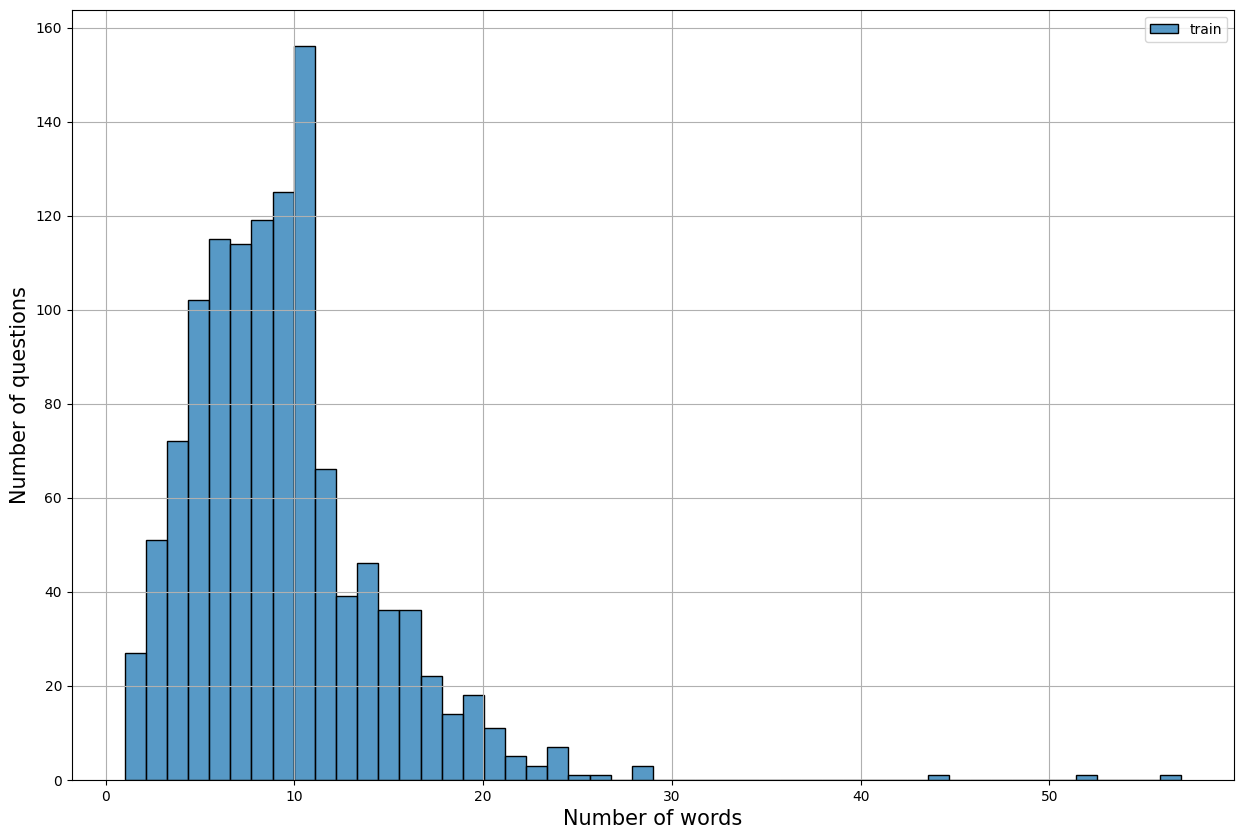

In [39]:
# 문장별 토큰 수 카운트
train_word_counts = clean_train_questions.apply(lambda x: len(x.split(' ')))

# 기초 통계량
display(pd.DataFrame(train_word_counts).describe().T)

# 분포 그래프
plt.figure(figsize = (15, 10))
sns.histplot(train_word_counts, bins = 50, label = 'train')
plt.legend()
plt.grid()
plt.xlabel('Number of words', fontsize = 15)
plt.ylabel('Number of questions', fontsize = 15)

In [40]:
# token_cnt = [len(sentence.split()) for sentence in clean_train_questions]

# for i, sentence in enumerate(clean_train_questions):
#     print("문장 {}: {}".format(i+1, sentence))
#     print("토큰 수: {}\n".format(token_cnt[i]))

In [41]:
# plt.figure(figsize = (12, 8))
# plt.subplot(1, 2, 1)
# plt.boxplot(token_cnt)

# plt.subplot(1, 2, 2)
# plt.hist(token_cnt)
# plt.show()

* 문장별 토큰이 가장 큰 것이 57개 입니다. 

* 학습 입력을 위한 데이터 크기 맞추기
    * 문장이 짧기 때문에 MAX_SEQUENCE_LENGTH는 정하지 않아도 되지만,
    * 그러나 분포를 보고 적절하게 자릅시다.
    * 그리고 pad_sequences 함수를 이용하여 시퀀스데이터로 변환하기
* y는 train['type'] 와 test['type'] 입니다.

In [42]:
MAX_SEQUENCE_LENGTH = 20

x_train = pad_sequences(x_train, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')
x_val = pad_sequences(x_val, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')

In [43]:
x_train.shape

(1192, 20)

In [44]:
y_train = train['type'].values
y_val = test['type'].values
y_train.shape, y_val.shape

((1192,), (106,))

#### 2) 모델링

* 토크나이징 한 데이터를 입력으로 받아 
* Embedding 레이어와 LSTM 레이어를 결합하여 이진 분류 모델링을 수행합니다.

In [45]:
# clear_session()

# model = Sequential()

# model.add(Embedding(vocab_size,
#                     32,
#                     input_length = MAX_SEQUENCE_LENGTH))
# model.add(LSTM(128, return_sequences=True))
# model.add(Dropout(0.2))

# model.add(LSTM(64, return_sequences=False))
# model.add(Dropout(0.2))

# model.add(Dense(1, activation = 'sigmoid'))

# model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [46]:
classifier_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim = 64),
    LSTM(32, return_sequences=True),
    LSTM(16),
    Dense(8),
    Dense(4),
    Dense(1, activation = 'sigmoid')
])

classifier_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          75008     
                                                                 
 lstm (LSTM)                 (None, None, 32)          12416     
                                                                 
 lstm_1 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 90,737
Trainable params: 90,737
Non-traina

In [47]:
y_val = y_val.astype(int)
y_val.dtype

dtype('int64')

In [48]:
es = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0,
                   patience = 5,
                   restore_best_weights = True,
                   verbose = 1)

In [49]:
classifier_model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])
history = classifier_model.fit(x_train, y_train, validation_split= 0.2, callbacks = [es], verbose = 1, epochs = 100)

Epoch 1/100
30/30 [==============================] - 15s 91ms/step - loss: 0.6274 - acc: 0.7062 - val_loss: 0.3992 - val_acc: 0.8703
Epoch 2/100
30/30 [==============================] - 1s 24ms/step - loss: 0.1051 - acc: 0.9748 - val_loss: 0.1379 - val_acc: 0.9582
Epoch 3/100
30/30 [==============================] - 1s 24ms/step - loss: 0.0032 - acc: 1.0000 - val_loss: 0.2467 - val_acc: 0.9456
Epoch 4/100
30/30 [==============================] - 1s 24ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.2799 - val_acc: 0.9456
Epoch 5/100
30/30 [==============================] - 1s 23ms/step - loss: 7.5175e-04 - acc: 1.0000 - val_loss: 0.2973 - val_acc: 0.9456
Epoch 6/100
30/30 [==============================] - 1s 24ms/step - loss: 5.3150e-04 - acc: 1.0000 - val_loss: 0.3103 - val_acc: 0.9456
Epoch 7/100
30/30 [==============================] - 1s 24ms/step - loss: 3.9844e-04 - acc: 1.0000 - val_loss: 0.3223 - val_acc: 0.9456
Epoch 7: early stopping


In [50]:
y_val = y_val.astype('int')
y_pred = classifier_model.predict(x_val)
y_pred = np.where(y_pred >= 0.5, 1, 0)

print(accuracy_score(y_val, y_pred))

4/4 [==============================] - 3s 6ms/step
0.9905660377358491


### (2) 사전학습모델(Word2Vec)

* Pre-trained Word2Vec model
    * 이미 다운로드 받아서 제공되었습니다.
        * ko.bin, ko.tsv
    * 참고 사이트: https://github.com/Kyubyong/wordvectors
        * 모델 파일 다운로드 사이트: https://drive.google.com/file/d/0B0ZXk88koS2KbDhXdWg1Q2RydlU/view?resourcekey=0-Dq9yyzwZxAqT3J02qvnFwg
* 사전학습 모델을 로딩하고, 
* train 데이터셋의 질문(Q)을 임베딩벡터로 만들어, 열(Column)로 추가합니다.

#### 1) 모델 로딩
* 사전 학습된 모델을 로딩 : gensim.models.Word2Vec.load()
* 로딩 후 벡터 크기를 조회합시다. .vector_size

In [51]:
import gensim
pre_wv_model = gensim.models.Word2Vec.load(path + 'ko.bin')

In [52]:
import gdown
if os.path.exists(os.path.join(path,'ko.zip')) is None:
    url = 'https://drive.google.com/open?id=0B0ZXk88koS2KbDhXdWg1Q2RydlU'
    output = os.path.join(path, 'ko.zip')
    gdown.download(url, output, fuzzy = True, quiet = False)
    import zipfile
    with zipfile.ZipFile(os.path.join(path, 'ko.zip'), 'r') as zip_ref:
        zip_ref.extractall(path)

In [53]:
# 모델의 벡터크기 확인
pre_wv_model.vector_size

200

#### 2) train 에 임베딩벡터 결과 저장
* get_sent_embedding 함수를 이용하여 train의 질문별 임베딩 결과를 저장합니다.
    * .apply(lambda .....) 를 활용하세요.

In [54]:
train['w2v'] = train['Q'].apply(lambda sent: get_sent_embedding(pre_wv_model, pre_wv_model.vector_size, tokenize('kkma', sent)))

### (3) 챗봇 구축
* 아래 절차대로 수행하는 함수 만들기
    * input 질문 
    * 1단계 : 모델을 이용하여 type 0, 1로 분류
    * 2단계 : 
        * train의 모든 Q와 input 문장의 임베딩 벡터간의 코사인 유사도 계산
        * 코사인 유사도가 가장 높은 Q를 선택
        * 선택한 Q의 intent에 맵핑된 답변 중 하나를 무작위로 선택

#### 1) 하나의 질문으로 테스트해보기

* 선택된 질문과 답변

In [55]:
train.iloc[1]

intent                                                    1
Q                                                    액정 나갔어
A                                                  as 맡기세요.
type                                                      0
w2v       [-0.12139579, -0.10291043, 0.16500081, 0.59794...
Name: 1, dtype: object

In [56]:
test_question = test['Q'].iloc[0]
print('질문: ', test_question)
print('답변: ', test['A'].iloc[0])
print('세부 카테고리: ', test['intent'].iloc[0])

질문:  핸드폰 맛이 갔어
답변:  AS센터에 맡겨보세요.
세부 카테고리:  1


* 예측을 위한 입력 형태로 변환
    * 학습을 위한 전처리 과정을 test 데이터에도 적용합니다. 

In [57]:
tokenized_sent = tokenize('mecab', test_question)
tokenized_sent_seq = token.texts_to_sequences([tokenized_sent])
tokenized_sent_input = pad_sequences(tokenized_sent_seq, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')

* 1단계 : type 분류

In [58]:
pred_type = classifier_model.predict(tokenized_sent_input)
pred_type = np.where(pred_type >= 0.5, 1, 0)[0][0]
pred_type

1/1 [==============================] - 0s 33ms/step


0

* 2단계 : 질문에 대한 벡터 만들고 코사인 유사도 계산
    * Word2Vec 사전 학습 모델로 부터 벡터 만들기

In [59]:
# 문장을 Word2Vec 모델을 사용하여 벡터화
test_question_w2v = get_sent_embedding(pre_wv_model, pre_wv_model.vector_size, tokenize('kkma', test_question))

* train의 질문 벡터들과 유사도 계산
    * Word2Vec 으로 만든 벡터들과 유사도 계산

In [60]:
from sklearn.metrics.pairwise import cosine_similarity

# train_data_vecs

temp_df = train[train['type'] == pred_type].copy()

temp_df['cossim_w2v'] = temp_df['w2v'].apply(lambda x: cosine_similarity([test_question_w2v]))
temp_df.head()

,intent,Q,A,type,w2v,cossim_w2v
0,1,떨어뜨려서 핸드폰 액정 나갔어,as 맡기세요.,0,"[-0.23370771, 0.20710802, -0.07017105, -0.3061...",[[0.9999999]]
1,1,액정 나갔어,as 맡기세요.,0,"[-0.12139579, -0.10291043, 0.16500081, 0.59794...",[[0.9999999]]
3,1,노트북이 작동이 안되네,AS센터에 맡겨보세요.,0,"[0.49900135, -0.07279079, 0.74073327, -0.31910...",[[0.9999999]]
4,1,노트북 키보드가 안먹히네,AS센터에 맡겨보세요.,0,"[0.8356018, -0.9253282, 0.6200317, -0.1324172,...",[[0.9999999]]
5,1,노트북 전원이 안들어와.,AS센터에 맡겨보세요.,0,"[0.052662883, 0.030067995, 0.69057053, -0.1872...",[[0.9999999]]


#### 2) 챗봇 함수 만들기
* 위 테스트 결과를 바탕으로 코드를 정리하고 함수로 생성합니다.

In [113]:
def get_answer2(question): 
    tokenized_sent = tokenize('kkma', question)
    # print(tokenized_sent)
    tokenized_sent_seq = token.texts_to_sequences([tokenized_sent])
    tokenized_sent_input = pad_sequences(tokenized_sent_seq, maxlen=MAX_SEQUENCE_LENGTH, padding = 'post')

    pred_type = classifier_model.predict(tokenized_sent_input)
    pred_type = np.where(pred_type >= 0.5, 1, 0)[0][0]
    test_question_w2v = get_sent_embedding(pre_wv_model, pre_wv_model.vector_size, tokenize('kkma', question))

    # intent label classification으로 코사인 유사도 계산량을 줄일 수 있다.
    temp_df = train[train['type'] == pred_type].copy()
    temp_df['cossim_w2v'] = temp_df['w2v'].apply(lambda x: cosine_similarity([test_question_w2v], [x])[0])

    intent_idx = temp_df.sort_values(['cossim_w2v'], ascending=False).head(1)['intent'].values[0]
    answers = train.loc[train['intent']==intent_idx, 'A'].unique()
    answer = np.random.choice(answers)

    return answer, intent_idx

In [114]:
question = '지원 자격이 궁금해요'
get_answer2(question)

1/1 [==============================] - 0s 28ms/step


('KT 에이블스쿨은 정규 4년제 대학 졸업자 및 졸업예정자 중 만 34세 이하 미취업자를 대상으로 하는 교육입니다.\n단, 모집시점에 만 35세여도 해당연도 1월 1일 이후 생일자는 지원이 가능합니다.\n또한 전공의 종류와는 무관 합니다.',
 31)

#### 3) test 데이터에 대해서 성능 측정하기

test 데이터 전체에 대해서 성능을 측정해 봅시다.

In [115]:
ct = 0
for idx, row in test.iterrows():
    print('질문: ', row['Q'])
    answer, intent_idx = get_answer2(row['Q'])
    print('예상 타입: ', answer)
    print('=' * 200)
    if intent_idx == row['intent']:
        ct += 1

print(ct, test.shape[0])

질문:  핸드폰 맛이 갔어
1/1 [==============================] - 0s 25ms/step
예상 타입:  as 맡기세요.
질문:  핸드폰 떨어뜨려서 고장 났나봐
1/1 [==============================] - 0s 25ms/step
예상 타입:  as 맡기세요.
질문:  건강이 최고
1/1 [==============================] - 0s 34ms/step
예상 타입:  가장 중요한 거예요.
질문:  이번년도는 꼭 집을 장만할거야
1/1 [==============================] - 0s 36ms/step
예상 타입:  공부는 끝이 없죠.
질문:  바람이 너무 많이 부네
1/1 [==============================] - 0s 28ms/step
예상 타입:  감기 조심 하세요.
질문:  너무 추워서 몸이 얼어붙을 것 같아
1/1 [==============================] - 0s 28ms/step
예상 타입:  감기 조심 하세요.
질문:  일요일에 교회끝나고 어디 가고 싶어.
1/1 [==============================] - 0s 27ms/step
예상 타입:  저도요!
질문:  개곡 가자고 하면 갈까?
1/1 [==============================] - 0s 26ms/step
예상 타입:  같이 가보세요.
질문:  항상 선택할 때 힘들어
1/1 [==============================] - 0s 38ms/step
예상 타입:  힘들 때네요.
질문:  mmm
1/1 [==============================] - 0s 36ms/step
예상 타입:  AS센터에 맡겨보세요.
질문:  고3이니까 공부해야겠지
1/1 [==============================] - 0s 35ms/step
예상 타입:  공부는 언제나 좋죠.
질문:  취직하면 공부 안해도 되는줄 알았는데


## 4.챗봇3

* **세부요구사항**
    * 단계별 챗봇을 만들어 봅시다.
        * 1단계 : 챗봇2의 1단계 모델을 사용합니다.
        * 2단계 : 
            * 각 type에 맞게, 사전학습된 Word2Vec 모델을 사용하여 임베딩 벡터(train)를 만들고
        * 3단계 : 챗봇 만들기
            * input 문장과 train 임베딩 벡터와 코사인 유사도 계산
            * 가장 유사도가 높은 질문의 intent 찾아
            * 해당 intent의 답변 중 무작위로 하나를 선정하여 답변하기

### (1) 1단계 : type 분류 모델링
- LSTM : 3-(1) 모델을 그대로 사용합니다.

In [ ]:
clear_session()

model = Sequential()

model.add(Embedding(vocab_size,
                    32,
                    input_length = MAX_SEQUENCE_LENGTH))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 32)            37472     
                                                                 
 lstm (LSTM)                 (None, 30, 128)           82432     
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 169,377
Trainable params: 169,377
Non-trai

### (2) FastText 모델

-  FastText 모델 학습을 위한 입력 포맷 2차원 리스트 형태 입니다.
  ```
  [['나', '는', '학생', '이다'], ['오늘', '은', '날씨', '가', '좋다']]
  ```

- Word2Vec계열의 FastText를 학습하는 이유
  - n-gram이 추가된 fasttext 모델은 유사한 단어에 대한 임베딩을 word2vec보다 잘 해결할 수 있으며, 오탈자 등에 대한 임베딩 처리가 가능하다.
  - 예) 체크카드, 쳌카드는 word2vec에서는 전혀 다른 단어이지만 fasttext는 character n-gram으로 비교적 같은 단어로 처리할 수 있다.
- 참고: https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText


#### 1) 데이터 준비
* 시작데이터 : clean_train_questions, clean_test_questions

* FastText를 위한 입력 데이터 구조 만들기

In [74]:
fasttext_train_sentences = [x.split(' ') for x in clean_train_questions.values]

#### 2) FastText 모델 생성
* FastText 문법
    * FastText( input데이터,  min_count = , size= , window=  )
        * input데이터 : 학습에 사용할 문장으로 이루어진 리스트
        * min_count : 모델에 사용할 단어의 최소 빈도수. 이 값보다 적게 출현한 단어는 모델에 포함되지 않음. 기본값 = 5
        * size : 단어의 벡터 차원 지정. 기본값 = 100
        * window : 학습할 때 한 단어의 좌우 몇 개의 단어를 보고 예측을 할 것인지를 지정. 기본값 = 5
    * 참조 : https://radimrehurek.com/gensim/models/fasttext.html#gensim.models.fasttext.FastText

In [75]:
from gensim.models.fasttext import FastText
import gensim.models.word2vec

model_ft = FastText(fasttext_train_sentences, min_count = 2, size = 200, window = 3)
print(model_ft)

FastText(vocab=718, size=200, alpha=0.025)


#### 3) train에 임베딩벡터 결과 저장
* get_sent_embedding 함수를 이용하여 train의 질문별 임베딩 결과를 저장합니다.
    * .apply(lambda .....) 를 활용하세요.

In [ ]:
train_embed2 = train.apply(lambda x: get_sent_embedding(pre_wv_model, 200, x['Q']), axis = 1)

In [77]:
train['ft_vec'] = train['Q'].apply(lambda sent: get_sent_embedding(model_ft, model_ft.vector_size, tokenize('kkma', sent)))
train.head()

,intent,Q,A,type,w2v,ft_vec
0,1,떨어뜨려서 핸드폰 액정 나갔어,as 맡기세요.,0,"[-0.23370771, 0.20710802, -0.07017105, -0.3061...","[0.06485318, 0.008215666, 0.025734935, -0.0206..."
1,1,액정 나갔어,as 맡기세요.,0,"[-0.12139579, -0.10291043, 0.16500081, 0.59794...","[0.09360883, 0.01331646, 0.03811614, -0.028295..."
3,1,노트북이 작동이 안되네,AS센터에 맡겨보세요.,0,"[0.49900135, -0.07279079, 0.74073327, -0.31910...","[0.12314838, 0.017638627, 0.048757184, -0.0381..."
4,1,노트북 키보드가 안먹히네,AS센터에 맡겨보세요.,0,"[0.8356018, -0.9253282, 0.6200317, -0.1324172,...","[0.085724756, 0.011680843, 0.03480952, -0.0261..."
5,1,노트북 전원이 안들어와.,AS센터에 맡겨보세요.,0,"[0.052662883, 0.030067995, 0.69057053, -0.1872...","[0.08026114, 0.011861353, 0.030793438, -0.0260..."


### (3) 챗봇 구축
- input 질문
- intent classifier로 common와 faq 중 하나를 예측
- 예측된 intent에 속한 train의 모든 Q와 input 문장의 임베딩 벡터간의 코사인 유사도 계산
- 코사인 유사도가 가장 높은 top-3개의 Q를 선택
- 선택한 Q에 맵핑된 답변 중 하나를 선택하고 실제 답변과 비교

#### 1) 하나의 질문으로 테스트해보기

* 선택된 질문과 답변

In [78]:
test_question = test['Q'].iloc[0]
print('질문: ', test_question)
print('답변: ', test['A'].iloc[0])
print('세부 카테고리: ', test['intent'].iloc[0])

질문:  핸드폰 맛이 갔어
답변:  AS센터에 맡겨보세요.
세부 카테고리:  1


* 예측을 위한 입력 형태로 변환

In [79]:
tokenized_sent = tokenize('mecab', test_question)
tokenized_sent_seq = token.texts_to_sequences([tokenized_sent])
tokenized_sent_input = pad_sequences(tokenized_sent_seq, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')

* 예측하기

In [80]:
pred_type = classifier_model.predict(tokenized_sent_input)
pred_type = np.where(pred_type >= 0.5, 1, 0)[0][0]
pred_type

1/1 [==============================] - 0s 47ms/step


0

* 질문에 대한 벡터 만들기
    * FestText 모델로 부터 벡터 만들기

In [83]:
test_question_ft = get_sent_embedding(model_ft, model_ft.vector_size, tokenized_sent)

* train의 질문 벡터들과 유사도 계산
    * FastText 로 만들 벡터들과 유사도 계산

In [85]:
from sklearn.metrics.pairwise import cosine_similarity

temp_df = train[train['type'] == pred_type].copy()

temp_df['cossim_ft'] = temp_df['ft_vec'].apply(lambda x: cosine_similarity([test_question_ft]))
temp_df.head()

,intent,Q,A,type,w2v,ft_vec,cossim_ft
0,1,떨어뜨려서 핸드폰 액정 나갔어,as 맡기세요.,0,"[-0.23370771, 0.20710802, -0.07017105, -0.3061...","[0.06485318, 0.008215666, 0.025734935, -0.0206...",[[1.0000001]]
1,1,액정 나갔어,as 맡기세요.,0,"[-0.12139579, -0.10291043, 0.16500081, 0.59794...","[0.09360883, 0.01331646, 0.03811614, -0.028295...",[[1.0000001]]
3,1,노트북이 작동이 안되네,AS센터에 맡겨보세요.,0,"[0.49900135, -0.07279079, 0.74073327, -0.31910...","[0.12314838, 0.017638627, 0.048757184, -0.0381...",[[1.0000001]]
4,1,노트북 키보드가 안먹히네,AS센터에 맡겨보세요.,0,"[0.8356018, -0.9253282, 0.6200317, -0.1324172,...","[0.085724756, 0.011680843, 0.03480952, -0.0261...",[[1.0000001]]
5,1,노트북 전원이 안들어와.,AS센터에 맡겨보세요.,0,"[0.052662883, 0.030067995, 0.69057053, -0.1872...","[0.08026114, 0.011861353, 0.030793438, -0.0260...",[[1.0000001]]



#### 2) 함수로 생성하기

In [120]:
def get_answer3(question): 
    tokenized_sent = tokenize('mecab', question)
    tokenized_sent_seq = token.texts_to_sequences([tokenized_sent])
    tokenized_sent_input = pad_sequences(tokenized_sent_seq, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')

    pred_type = classifier_model.predict(tokenized_sent_input)
    pred_type = np.where(pred_type >= 0.5, 1, 0)[0][0]

    test_question_ft = get_sent_embedding(model_ft, model_ft.vector_size, tokenize('mecab', question))

    # intent label classification으로 코사인 유사도 계산량을 줄일 수 있다.
    temp_df = train[train['type'] == pred_type].copy()
    temp_df['cossim_ft'] = temp_df['ft_vec'].apply(lambda x: cosine_similarity([test_question_ft], [x])[0])

    intent_idx = temp_df.sort_values(['cossim_ft'], ascending=False).head(1)['intent'].values[0]
    answers = train.loc[train['intent']==intent_idx, 'A'].unique()
    answer = np.random.choice(answers)

    return answer, intent_idx

In [121]:
def get_answer33(question): 
    tokenized_sent = tokenize('mecab', question)
    tokenized_sent_seq = token.texts_to_sequences([tokenized_sent])
    tokenized_sent_input = pad_sequences(tokenized_sent_seq, maxlen = MAX_SEQUENCE_LENGTH, padding = 'post')

    pred_type = classifier_model.predict(tokenized_sent_input)
    pred_type = np.where(pred_type >= 0.5, 1, 0)[0][0]

    test_question_ft = get_sent_embedding(model_ft, model_ft.vector_size, tokenize('mecab', question))

    # intent label classification으로 코사인 유사도 계산량을 줄일 수 있다.
    temp_df = train[train['type'] == pred_type].copy()
    temp_df['cossim_ft'] = temp_df['ft_vec'].apply(lambda x: cosine_similarity([test_question_ft], [x])[0])

    intent_idx = temp_df.sort_values(['cossim_ft'], ascending=False).head(3).index
    choiced_idx = np.random.choice(intent_idx)
    answer = train.loc[choiced_idx, 'A']

    return answer, train.loc[choiced_idx, 'intent']

In [122]:
question = '일요일에 교회끝나고 어디 가고 싶어.'
print(get_answer3(question))
print(get_answer33(question))

1/1 [==============================] - 0s 24ms/step
('가장 중요한 목표네요.', 2)
1/1 [==============================] - 0s 23ms/step
('가장 중요한 목표네요.', 2)


In [108]:
model_ft.wv.similar_by_word('나이')

[('따라갈', 0.996029257774353),
 ('가', 0.996012806892395),
 ('경우', 0.9959909915924072),
 ('는데', 0.9959530830383301),
 ('중', 0.9959491491317749),
 ('하', 0.9959413409233093),
 ('증명서', 0.9959395527839661),
 ('지원', 0.995895266532898),
 ('에', 0.9958906173706055),
 ('교육', 0.9958897829055786)]

#### 3) test 데이터에 대해서 성능 측정하기

test 데이터 전체에 대해서 성능을 측정해 봅시다.

In [125]:
ct = 0
ct3 = 0
for idx, row in test.iterrows():
    print('질문: ', row['Q'])
    answer, intent_idx = get_answer3(row['Q'])
    answer3, intent_idx3 = get_answer33(row['Q'])
    print('예상 타입: ', answer)
    print('=' * 200)
    if intent_idx == row['intent']:
        ct += 1
    if intent_idx3 == row['intent']:
        ct3 += 1

print(ct, test.shape[0])
print(ct3, test.shape[0])

질문:  핸드폰 맛이 갔어
1/1 [==============================] - 0s 35ms/step
예상 타입:  힘들겠네요.
질문:  핸드폰 떨어뜨려서 고장 났나봐
1/1 [==============================] - 0s 34ms/step
예상 타입:  AS센터에 맡겨보세요.
질문:  건강이 최고
1/1 [==============================] - 0s 37ms/step
예상 타입:  가장 중요한 거예요.
질문:  이번년도는 꼭 집을 장만할거야
1/1 [==============================] - 0s 36ms/step
예상 타입:  냉장고 파먹기 해보세요.
질문:  바람이 너무 많이 부네
1/1 [==============================] - 0s 23ms/step
예상 타입:  감기 조심하세요!
질문:  너무 추워서 몸이 얼어붙을 것 같아
1/1 [==============================] - 0s 25ms/step
예상 타입:  감기 조심하세요.
질문:  일요일에 교회끝나고 어디 가고 싶어.
1/1 [==============================] - 0s 22ms/step
예상 타입:  가장 중요한 목표네요.
질문:  개곡 가자고 하면 갈까?
1/1 [==============================] - 0s 24ms/step
예상 타입:  같이 가보세요.
질문:  항상 선택할 때 힘들어
1/1 [==============================] - 0s 27ms/step
예상 타입:  성공적으로 끝날 거예요.
질문:  mmm
1/1 [==============================] - 0s 23ms/step
예상 타입:  AS센터에 맡겨보세요.
질문:  고3이니까 공부해야겠지
1/1 [==============================] - 0s 30ms/step
예상 타입:  공부는 언제나 좋죠.
질문:  취직하면

## 5.질문에 대한 답변 비교해보기

* **세부요구사항**
    * 세가지 챗봇을 생성해 보았습니다. 
    * 질문을 입력하여 답변을 비교해 봅시다. 어떤 챗봇이 좀 더 정확한 답변을 하나요?


In [124]:
question = '에이블스쿨 지원하고 싶어요'

ans1, int1 = get_answer1(question)
ans2, int2 = get_answer2(question)
ans3, int3 = get_answer3(question)

print('='*120)
print('질문: ', question)
print('='*120)
print('챗봇1 답변: ', int1, ans1)
print('-'*120)
print('챗봇2 답변: ', int2, ans2)
print('-'*120)
print('챗봇3 답변: ', int3, ans3)
print('='*120)

1/1 [==============================] - 0s 40ms/step
질문:  에이블스쿨 지원하고 싶어요
챗봇1 답변:  13 다 잘 될 거예요.
------------------------------------------------------------------------------------------------------------------------
챗봇2 답변:  21 보험 처리하세요.
------------------------------------------------------------------------------------------------------------------------
챗봇3 답변:  8 힘들 때네요.


In [102]:
tokenize('mecab', question)

'에이블 스쿨 지원 하 고 싶 어요'